In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import datetime
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression

import os
import IPython
import IPython.display
import matplotlib as mpl
import seaborn as sns

dir_path = "../data/"

In [2]:
train_val = pd.read_csv(dir_path + "ps6_trainvalid.csv")
test = pd.read_csv(dir_path + "ps6_test.csv")

# Preprocessing

In [3]:
train_val.isnull().sum()

datetime            0
temperature         3
humidity          152
pressure          252
weather             1
wind_direction      1
wind_speed          1
dtype: int64

In [4]:
train_val[train_val["temperature"].isnull()]

,datetime,temperature,humidity,pressure,weather,wind_direction,wind_speed
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN
3859,2013-03-11 07:00:00,NaN,12.0,1036.0,sky is clear,4.0,0.0
3860,2013-03-11 08:00:00,NaN,24.0,1036.0,sky is clear,9.0,1.0


In [5]:
train_val.wind_speed.value_counts()

1.0     17646
0.0     15582
2.0      5237
3.0      2682
4.0      1867
5.0      1263
6.0       456
7.0       156
8.0        54
9.0        29
10.0       14
11.0       11
12.0        4
16.0        4
15.0        2
13.0        2
14.0        2
17.0        1
Name: wind_speed, dtype: int64

In [6]:
train_val.wind_direction.value_counts()

0.0      6887
230.0    2119
260.0    1451
250.0    1422
270.0    1243
         ... 
303.0      11
358.0      11
341.0      10
289.0      10
302.0       9
Name: wind_direction, Length: 361, dtype: int64

## fill NAN with interpolation

In [7]:
train_val = train_val.interpolate(method='linear', limit_direction='forward', axis=0)
train_val = train_val.drop(0)

In [8]:
train_val.isnull().sum()

datetime          0
temperature       0
humidity          0
pressure          0
weather           0
wind_direction    0
wind_speed        0
dtype: int64

In [9]:
test.isnull().sum()

datetime          0
temperature       0
humidity          0
pressure          0
weather           0
wind_direction    0
wind_speed        0
dtype: int64

## Date, Time

In [10]:
train_val["datetime"] = pd.to_datetime(train_val["datetime"], format = "%Y-%m-%d %H:%M:%S")
test["datetime"] = pd.to_datetime(test["datetime"], format = "%Y-%m-%d %H:%M:%S")


date_time = train_val["datetime"]
date_time_test = test["datetime"]

timestamp_s = date_time.map(datetime.datetime.timestamp)
timestamp_s_test = date_time_test.map(datetime.datetime.timestamp)


day = 24*60*60
year = (365.2425)*day

train_val['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
train_val['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
train_val['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
train_val['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

test['Day sin'] = np.sin(timestamp_s_test * (2 * np.pi / day))
test['Day cos'] = np.cos(timestamp_s_test * (2 * np.pi / day))
test['Year sin'] = np.sin(timestamp_s_test * (2 * np.pi / year))
test['Year cos'] = np.cos(timestamp_s_test * (2 * np.pi / year))




In [11]:
date_time = train_val["datetime"]

In [12]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [13]:
day = 24*60*60
year = (365.2425)*day

train_val['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
train_val['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
train_val['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
train_val['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

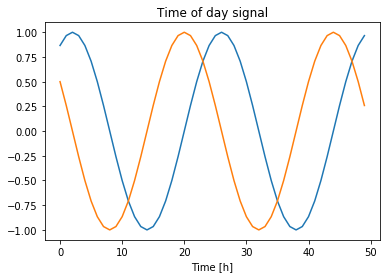

In [14]:
plt.plot(np.array(train_val['Day sin'])[:50])
plt.plot(np.array(train_val['Day cos'])[:50])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [15]:
train_val = train_val.drop("datetime", axis = 1)
test = test.drop("datetime", axis = 1)

## Weather

In [16]:
train_val["weather"].value_counts()

sky is clear                    25983
haze                             3490
mist                             2938
broken clouds                    2564
overcast clouds                  2432
scattered clouds                 2266
light rain                       1946
few clouds                       1754
fog                               560
moderate rain                     481
smoke                             203
heavy intensity rain              127
light intensity drizzle           102
dust                               64
proximity thunderstorm             25
very heavy rain                    20
thunderstorm                       17
thunderstorm with light rain       13
shower rain                         8
drizzle                             5
proximity shower rain               4
light intensity shower rain         3
squalls                             3
thunderstorm with rain              2
thunderstorm with heavy rain        2
Name: weather, dtype: int64

In [17]:
test["weather"].value_counts()

sky is clear               153
haze                        42
mist                        23
fog                          6
scattered clouds             5
light rain                   3
few clouds                   3
light intensity drizzle      2
dust                         2
broken clouds                1
Name: weather, dtype: int64

In [18]:
def clear (x):
    if x =="sky is clear":
        return 1
    else:
        return 0

def haze (x):
    if x == "drizzle" or x == "light intensity drizzle":
        return 3
    if x == "fog":
        return 2
    elif x == "haze" or x == "mist":
        return 1
    else:
        return 0
    
def cloud(x):
    if x == "broken clouds" or x == "scattered clouds" or x == "few clouds" or x == "squalls":
        return 1
    elif x == "overcast clouds":
        return 2
    else:
        return 0
    
def rain(x):
    if x == "light rain" or x == "drizzle" or x == "light intensity drizzle" or x == "light intensity shower rain" or x == "thunderstorm with light rain":
        return 1
    elif x == "moderate rain" or x == "shower rain" or x == "proximity shower rain" or x == "thunderstorm with rain":
        return 2
    
    elif x == "heavy intensity rain" or x == "thunderstorm with heavy rain":
        return 3
    elif x == "very heavy rain":
        return 4
    else:
        return 0

def dust(x):
    if x == "smoke":
        return 2
    if x =="dust":
        return 1
    else:
        return 0
    
def thunderstorm(x):
    if x == "thunderstorm" or x == "thunderstorm with light rain" or x == "thunderstorm with rain" or x =="thunderstorm with heavy rain" or x == "proximity thunderstorm":
        return 1
    else: 
        return 0


In [19]:
train_val["clear"] = train_val["weather"].apply(clear)
train_val["haze"] = train_val["weather"].apply(haze)
train_val["cloud"] = train_val["weather"].apply(cloud)
train_val["rain"] = train_val["weather"].apply(rain)
train_val["dust"] = train_val["weather"].apply(dust)
train_val["thunderstorm"] = train_val["weather"].apply(thunderstorm)

test["clear"] = test["weather"].apply(clear)
test["haze"] = test["weather"].apply(haze)
test["cloud"] = test["weather"].apply(cloud)
test["rain"] = test["weather"].apply(rain)
test["dust"] = test["weather"].apply(dust)
test["thunderstorm"] = test["weather"].apply(thunderstorm)


In [20]:
del train_val["weather"]
del test["weather"]

In [21]:
##### train_val_test.to_csv(dir_path+"preprocessed_train_val_test.csv")
train_val.to_csv(dir_path+"preprocessed_train_val.csv")
test.to_csv(dir_path + "preprocessed_test.csv")

# Visualization

In [98]:
train_val = pd.read_csv(dir_path+"preprocessed_train_val.csv", header=0, index_col=0)
test = pd.read_csv(dir_path+"preprocessed_test.csv", header=0, index_col=0)

In [100]:
train_val = train_val[["temperature", "Day sin", "Day cos", "Year sin", "Year cos"]]
test = test[["temperature", "Day sin", "Day cos", "Year sin", "Year cos"]]

In [101]:
train_val.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temperature,45012.0,290.841207,6.465209,266.503667,286.370000,2.905300e+02,295.080000,315.47
Day sin,45012.0,0.000104,0.707115,-1.000000,-0.707107,1.421321e-14,0.707107,1.00
Day cos,45012.0,-0.000135,0.707115,-1.000000,-0.707107,-8.736254e-15,0.707107,1.00
Year sin,45012.0,-0.023237,0.712145,-1.000000,-0.742946,-4.237423e-02,0.691941,1.00
Year cos,45012.0,0.010501,0.701585,-1.000000,-0.691948,3.857124e-02,0.697438,1.00


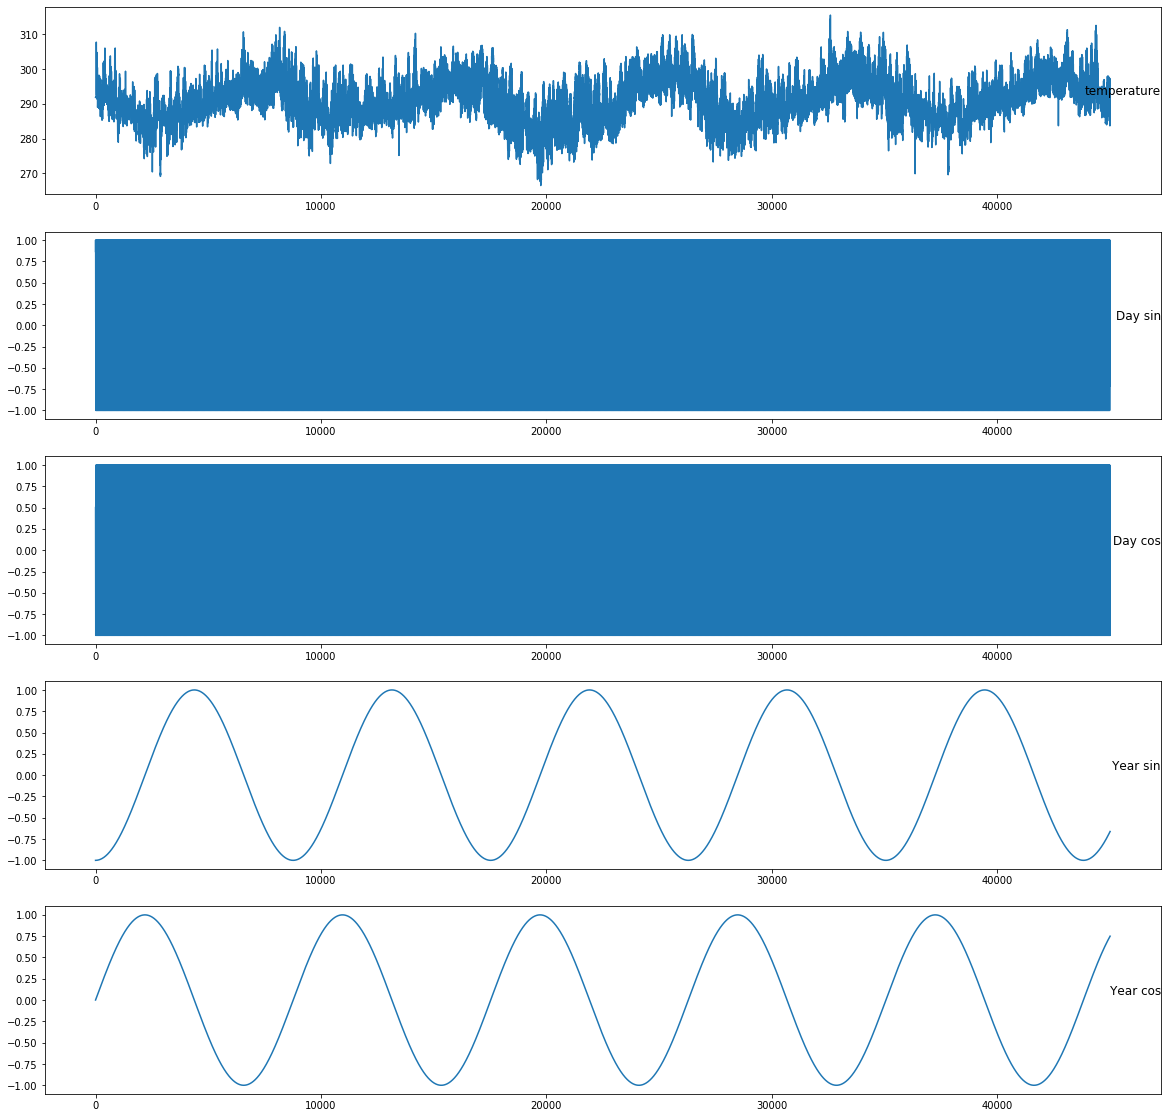

In [102]:
values = train_val.values
# specify columns to plot
groups = range(5)
i = 1
# plot each column
plt.figure(figsize=(20, 20))

for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(train_val.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

#https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

# Train Val Test Split

In [103]:
n = len(train_val)
train_df = train_val[0:int(n*0.8)]
val_df = train_val[int(n*0.8):]
test_df = test
num_features = train_val.shape[1]

# Normalization

In [104]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

# Baseline Model(Linear Regression)

### predicting temperature after 24 hours

In [105]:
## train set contains temperature, humidity and pressure of previous 24 hours

tmp = train_df[["temperature"]]

train_base = pd.concat([tmp.shift(i).rename(columns = {"temperature" : "temperature "+str(i)}) for i in range(24)], axis=1).iloc[24::24,::]

train_base["target"] = train_base.iloc[:,0].shift(-1)

train_base = train_base.iloc[:-1,:]

In [106]:
## train X, y
X = train_base.iloc[:,:-1]
y = train_base.iloc[:,-1]

In [107]:
reg = LinearRegression().fit(X, y)

In [108]:
tmp = test_df[["temperature"]]

test_base = pd.concat([tmp.shift(i).rename(columns = {"temperature" : "temperature "+str(i)}) for i in range(24)], axis=1).iloc[24::24,::]

test_base["target"] = test_base.iloc[:,0].shift(-1)

test_base = test_base.iloc[:-1,:]

In [109]:
## test X, y
test_X = test_base.iloc[:,:-1]
test_y = test_base.iloc[:,-1]

In [110]:
test_X

,temperature 0,temperature 1,temperature 2,temperature 3,temperature 4,temperature 5,temperature 6,temperature 7,temperature 8,temperature 9,...,temperature 14,temperature 15,temperature 16,temperature 17,temperature 18,temperature 19,temperature 20,temperature 21,temperature 22,temperature 23
24,0.621246,0.722909,0.860988,0.766912,0.680423,0.566621,0.232803,-0.149571,-0.650298,-1.076675,...,-1.014463,-0.964391,-0.824794,-0.723131,-0.627538,-0.524358,-0.248199,-0.087359,0.006717,0.349639
48,1.490691,1.583250,1.642427,1.772919,1.742572,1.420893,1.037002,0.598486,-0.013009,-0.503115,...,-0.395382,-0.331653,-0.348344,-0.442420,-0.286133,-0.242129,-0.069151,0.011269,0.188800,0.367848
72,2.021766,2.247852,2.398070,2.341928,2.302477,2.102186,1.662152,1.184185,0.475580,-0.384761,...,0.002165,-0.058529,0.024925,0.058307,0.097758,0.211560,0.474063,0.548413,0.794225,1.091627
96,1.734985,2.064252,2.126463,2.150741,2.149224,1.892790,1.542281,1.108317,0.474063,-0.132880,...,0.070446,0.291980,0.304119,0.455854,0.527170,0.572691,0.812433,0.906509,1.235775,1.537729
120,1.307091,1.527108,1.599941,1.610562,1.581732,1.334403,1.040036,0.604555,0.043134,-0.556222,...,-0.266407,-0.116189,-0.079772,0.049203,0.061342,0.354192,0.457372,0.669802,0.964169,1.279779
144,0.932304,1.155355,1.338956,1.378407,1.404202,1.258536,0.945960,0.499858,-0.078255,-0.588086,...,-0.360483,-0.231508,-0.148053,-0.069151,0.037064,0.102310,0.296532,0.457372,0.671319,0.959617
168,0.326879,0.531722,0.648559,0.631868,0.548413,0.334466,0.030995,-0.292202,-0.533462,-0.767134,...,-0.459111,-0.406004,-0.280063,-0.264890,-0.208747,-0.179918,-0.022113,0.085620,0.200939,0.487719
192,0.082585,0.194869,0.172109,0.102310,0.100793,-0.016043,-0.114671,-0.176883,-0.348344,-0.383243,...,-0.418143,-0.442420,-0.418143,-0.346827,-0.430281,-0.440903,-0.352896,-0.287650,-0.158675,0.012786


In [111]:
pred = reg.predict(test_X)

In [112]:
print("Performance(mae) :", sum(abs(pred-test_y))/len(pred))

Performance(mae) : 0.7221289167170999


Feature: temperature 0, Score: 0.19078
Feature: temperature 1, Score: 0.47394
Feature: temperature 2, Score: -0.02623
Feature: temperature 3, Score: -0.01867
Feature: temperature 4, Score: 0.04457
Feature: temperature 5, Score: -0.04297
Feature: temperature 6, Score: -0.02673
Feature: temperature 7, Score: 0.08929
Feature: temperature 8, Score: -0.10172
Feature: temperature 9, Score: 0.01003
Feature: temperature 10, Score: -0.11076
Feature: temperature 11, Score: 0.14338
Feature: temperature 12, Score: 0.02456
Feature: temperature 13, Score: 0.18786
Feature: temperature 14, Score: 0.38413
Feature: temperature 15, Score: -0.34959
Feature: temperature 16, Score: 0.17847
Feature: temperature 17, Score: -0.18143
Feature: temperature 18, Score: -0.22768
Feature: temperature 19, Score: 0.21021
Feature: temperature 20, Score: -0.03104
Feature: temperature 21, Score: -0.01812
Feature: temperature 22, Score: 0.00320
Feature: temperature 23, Score: 0.07619


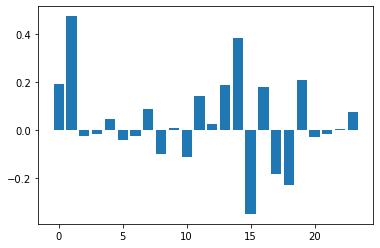

In [113]:
## feature importance
importance = reg.coef_
a = list(train_base.columns)*24
# summarize feature importance
importance_dict = dict()
for i,v in enumerate(importance):
    print('Feature: %0s, Score: %.5f' % (a[i],v))
    importance_dict[a[i]] = v
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

#https://machinelearningmastery.com/calculate-feature-importance-with-python/

In [114]:
sorted(list(importance_dict.items()), key = lambda x : -abs(x[1]))

[('temperature 1', 0.47393824712214827),
 ('temperature 14', 0.38413487858456746),
 ('temperature 15', -0.34959437704667073),
 ('temperature 18', -0.22768241039616702),
 ('temperature 19', 0.21021266860867394),
 ('temperature 0', 0.19078423720450524),
 ('temperature 13', 0.1878592194902618),
 ('temperature 17', -0.18142774468122072),
 ('temperature 16', 0.17847288414799506),
 ('temperature 11', 0.143377042536722),
 ('temperature 10', -0.11076472981236878),
 ('temperature 8', -0.10172421008106222),
 ('temperature 7', 0.08929407607186537),
 ('temperature 23', 0.07618633026938924),
 ('temperature 4', 0.044573864608815406),
 ('temperature 5', -0.042966917670081504),
 ('temperature 20', -0.031042962956861563),
 ('temperature 6', -0.026730584774245322),
 ('temperature 2', -0.026229294657548932),
 ('temperature 12', 0.02455731410599285),
 ('temperature 3', -0.018665240715444835),
 ('temperature 21', -0.018122640175718293),
 ('temperature 9', 0.01002576145694497),
 ('temperature 22', 0.0032040

In [115]:
column_indices = {name: i for i, name in enumerate(train_val.columns)}

In [116]:
column_indices

{'temperature': 0, 'Day sin': 1, 'Day cos': 2, 'Year sin': 3, 'Year cos': 4}

# Windowing Data

In [117]:
#https://www.tensorflow.org/tutorials/structured_data/time_series

class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
        train_df=train_df, val_df=val_df, test_df=test_df, label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

          # Slicing doesn't preserve static shape information, so set the shapes
          # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

      # Slicing doesn't preserve static shape information, so set the shapes
      # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

def plot(self, model=None, plot_col='temperature', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

WindowGenerator.split_window = split_window
WindowGenerator.plot = plot
WindowGenerator.make_dataset = make_dataset

In [118]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2, MAX_EPOCHS = 20):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [119]:
w2 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['temperature'])
w2

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['temperature']

In [120]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 48, 5)
Inputs shape: (3, 24, 5)
labels shape: (3, 1, 1)


# Baseline model for single shot

## just copies temperature of previous 24 hours 

In [121]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['temperature'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['temperature']

In [122]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [123]:
baseline = Baseline(label_index=column_indices['temperature'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

282/282 [==============================] - 1s 2ms/step - loss: 0.0311 - mean_absolute_error: 0.1238


In [124]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=24,
    label_columns=['temperature'])

wide_window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['temperature']

In [125]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)

Input shape: (32, 1, 5)
Output shape: (32, 1, 1)


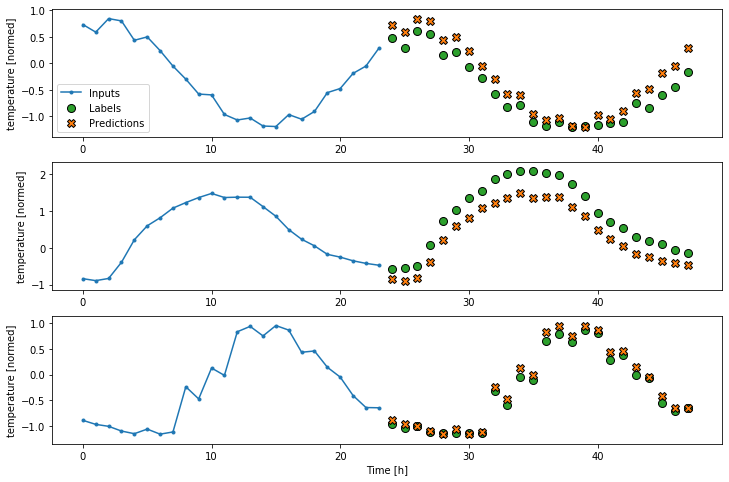

In [126]:
wide_window.plot(baseline)

# Linear model

## Using Dense layere without activation

In [127]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [128]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 5)
Output shape: (32, 1, 1)


In [129]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1126/1126 [==============================] - 3s 2ms/step - loss: 1.8765 - mean_absolute_error: 1.0712 - val_loss: 0.1017 - val_mean_absolute_error: 0.2590
Epoch 2/20
1126/1126 [==============================] - 3s 2ms/step - loss: 0.0771 - mean_absolute_error: 0.2042 - val_loss: 0.0206 - val_mean_absolute_error: 0.1042
Epoch 3/20
1126/1126 [==============================] - 3s 2ms/step - loss: 0.0439 - mean_absolute_error: 0.1379 - val_loss: 0.0198 - val_mean_absolute_error: 0.1020
Epoch 4/20
1126/1126 [==============================] - 3s 3ms/step - loss: 0.0433 - mean_absolute_error: 0.1381 - val_loss: 0.0200 - val_mean_absolute_error: 0.1026
Epoch 5/20
282/282 [==============================] - 1s 2ms/step - loss: 0.0203 - mean_absolute_error: 0.1038


In [130]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 5)
Output shape: (32, 24, 1)


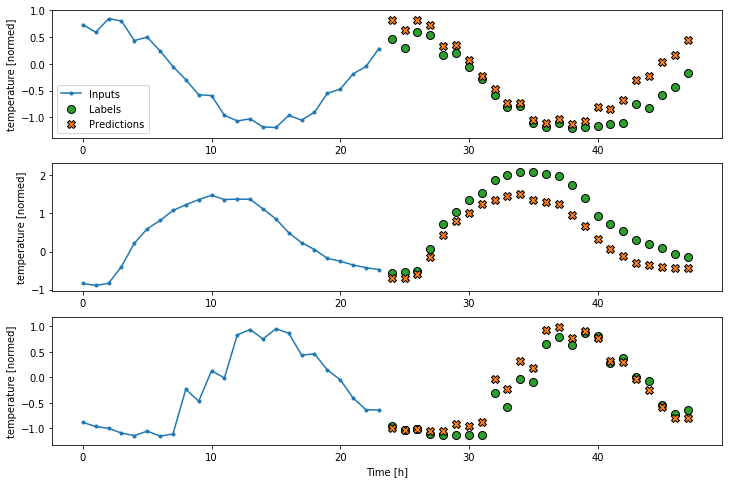

In [131]:
wide_window.plot(linear)

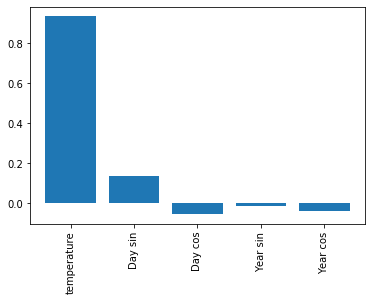

In [132]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

# Multi Step Labels

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

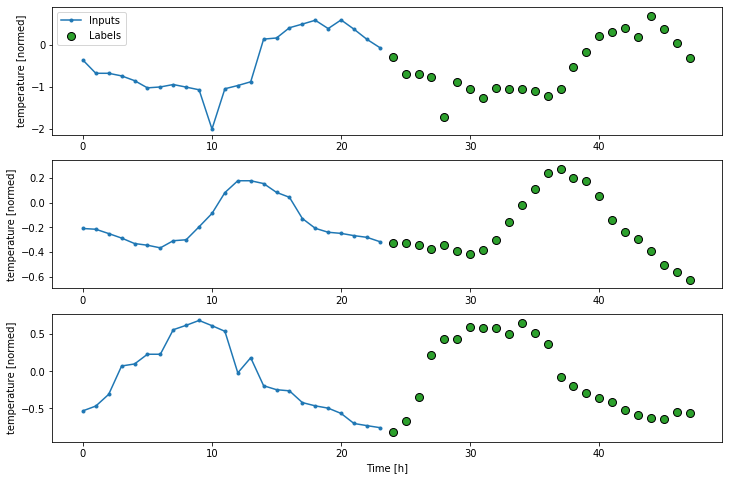

In [133]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

# Multi Step BaseLine ( keeping the last temperature)

280/280 [==============================] - 1s 2ms/step - loss: 0.9199 - mean_absolute_error: 0.5792


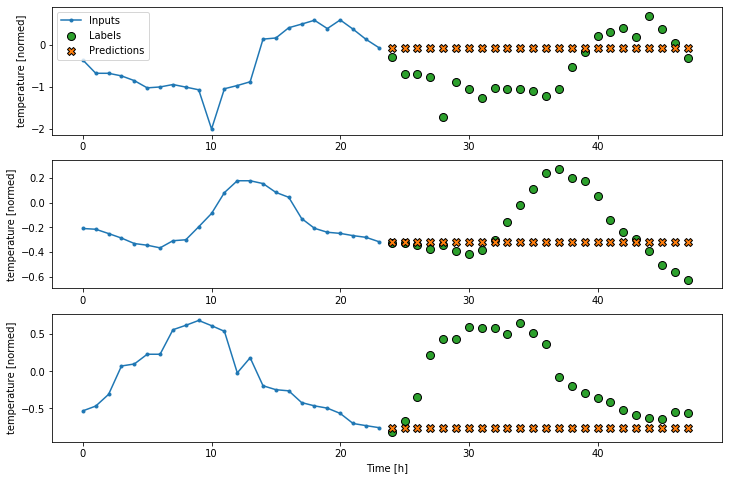

In [134]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.val, verbose=0)
multi_window.plot(last_baseline)

# Repeat Baseline (Repeating previouse 24 hour temperature)

280/280 [==============================] - 1s 2ms/step - loss: 0.0232 - mean_absolute_error: 0.0554


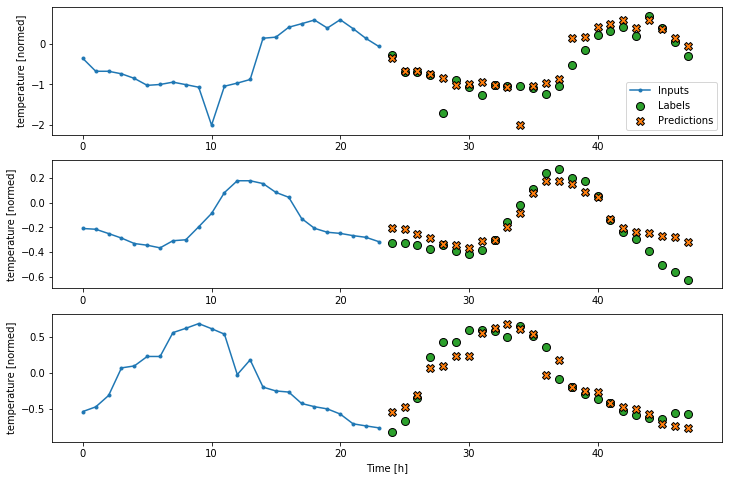

In [135]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

# Linear Model

280/280 [==============================] - 1s 3ms/step - loss: 0.0325 - mean_absolute_error: 0.0625


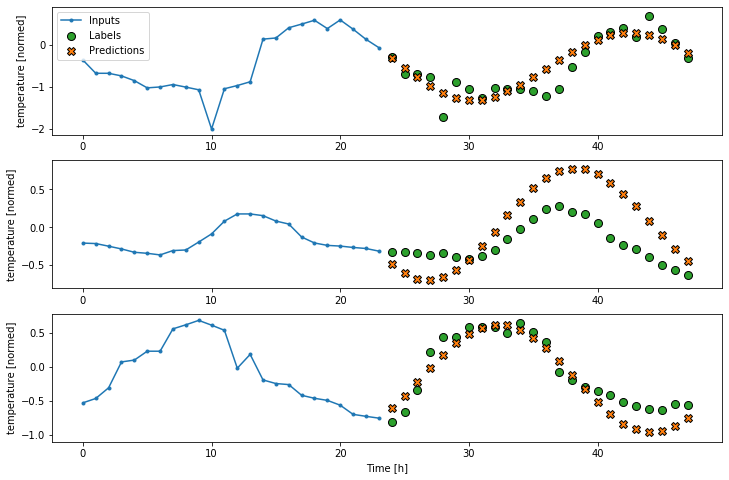

In [136]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

# Dense Model Ising Relu Activation Function

280/280 [==============================] - 1s 3ms/step - loss: 0.0279 - mean_absolute_error: 0.0624


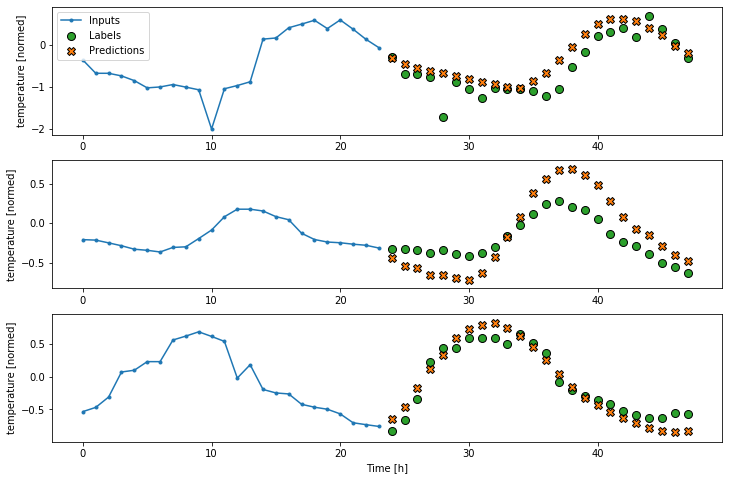

In [137]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

# Convolutional model using Conv1D

280/280 [==============================] - 1s 3ms/step - loss: 0.0280 - mean_absolute_error: 0.0660


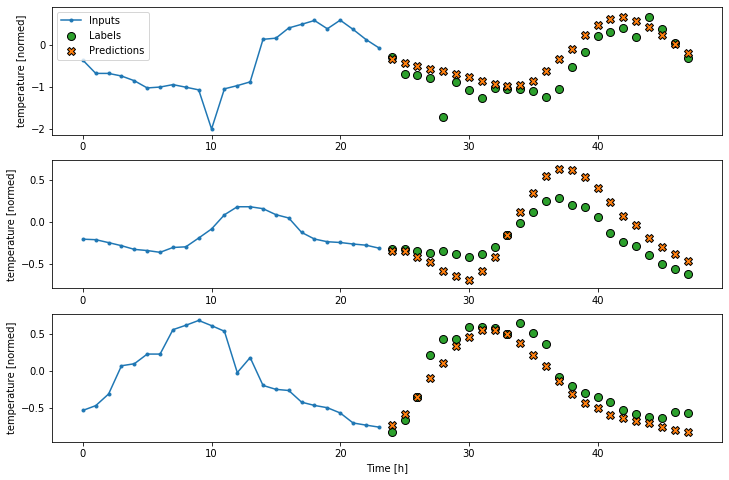

In [138]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

# LSTM model

280/280 [==============================] - 1s 4ms/step - loss: 0.0188 - mean_absolute_error: 0.0584


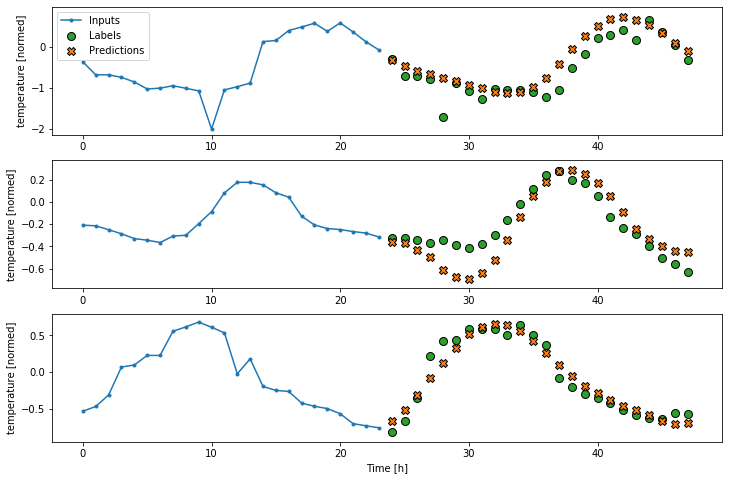

In [139]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

# Self FeedBack Model

In [140]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

In [141]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [142]:
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [143]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 5])

In [144]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call



In [145]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 5)


280/280 [==============================] - 2s 5ms/step - loss: 0.0215 - mean_absolute_error: 0.0644


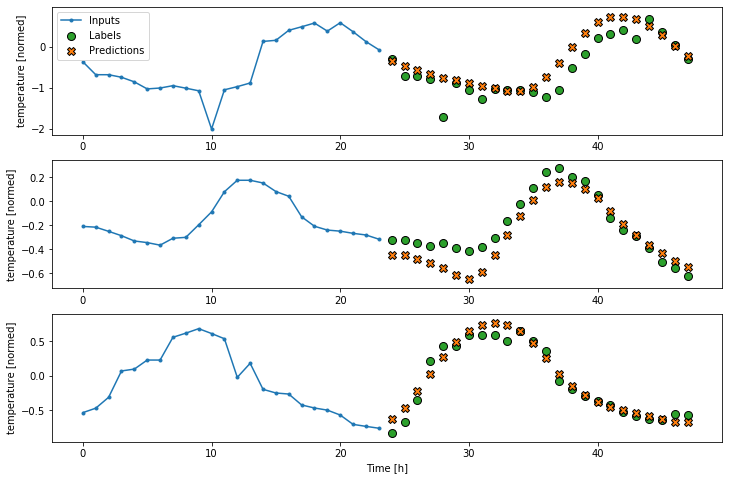

In [146]:
history = compile_and_fit(feedback_model, multi_window, MAX_EPOCHS = 50)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

# Model Result

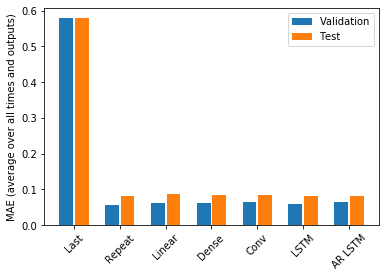

In [147]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [148]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5792
Repeat  : 0.0822
Linear  : 0.0863
Dense   : 0.0855
Conv    : 0.0844
LSTM    : 0.0804
AR LSTM : 0.0817


In [149]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5792
Repeat  : 0.0822
Linear  : 0.0863
Dense   : 0.0855
Conv    : 0.0844
LSTM    : 0.0804
AR LSTM : 0.0817


In [150]:
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

In [151]:
val_mae

[0.5792019963264465,
 0.05515778437256813,
 0.06247084587812424,
 0.06243324652314186,
 0.06595618277788162,
 0.05842236056923866,
 0.06439679116010666]

In [152]:
test_mae

[0.5792017579078674,
 0.08219559490680695,
 0.08632116764783859,
 0.08549261093139648,
 0.08442797511816025,
 0.08044005185365677,
 0.0816691592335701]